In [1]:
import os
import matplotlib.pyplot as plt
import datetime
import time
import matplotlib.gridspec as gridspec

import pickle
import numpy as np
import pandas as pd
import seaborn as sns

from itertools import compress

from helpers.expr_data import ExprData
from helpers.scale_data import ScaleData
from helpers.similarity import Similarity
from helpers.feature_selection import FeatureSelection

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
from sklearn.metrics import root_mean_squared_error as rmse_score
from sklearn.metrics import make_scorer

import warnings
warnings.filterwarnings("ignore")

In [2]:
SMALL_SIZE = 15
MEDIUM_SIZE = 18
BIGGER_SIZE = 22
SMALL_SMALL_SIZE = 10

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
# plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize

plt.rc('legend', fontsize=SMALL_SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [3]:
OVERALL_PLOT = True

In [4]:
X_label = 'SKU'
expr_label = 'EXPR'
y_true_label = 'Y_TRUE'
y_pred_label = 'Y_PRED'
suffix_labels = ['_small', '_large']

In [5]:
import random
np.random.seed(47907)
random.seed(47907)

In [6]:
def nrmse_score(y_true, y_pred):
    return rmse_score(y_true, y_pred)/(np.max(y_true)-np.min(y_true))
score_func = make_scorer(nrmse_score, greater_is_better=False)

In [7]:
# read in the performance metrics for each experiment
data_all = ExprData()
data_all.load_pickle()
data = data_all.remove_by_wlname(['xml', 'ycsb'])
ycsb_data = data_all.remove_by_wlname(['xml', 'tpcc', 'tpch', 'twitter'])

In [8]:
# data = data.fix_tpch()
data = data.merge_tpch()

In [9]:
# similarity for all
new_data = data.keep_complete_exprs()

scaler = ScaleData()
plan_mtxs, plan_col_ranges = scaler.scale(new_data.plan_mtxs)
perf_mtxs, perf_col_ranges = scaler.scale(new_data.perf_mtxs)

simi_calc_all = Similarity(new_data, plan_mtxs, plan_col_ranges, perf_mtxs, perf_col_ranges)
simi_calc_all.calc_bined_mtx() # all plan features

simi_calc = simi_calc_all
fs = FeatureSelection(simi_calc)

all_top_7 = fs.select_features(7, 'fANOVA', est_name=None, direction=None, feature_type=None)

(108, 108, 29)


In [10]:
sampled_data = new_data.sample_data()

In [11]:
data_by_type = sampled_data.split_by_type()

In [12]:
sampled_by_type = sampled_data.split_by_type()
for ty, expr_set in sampled_by_type.items():
    sub_by_term = expr_set.split_by_term()
    sampled_by_type[ty] = sub_by_term

In [13]:
def get_cpu_nums_as_X(l):
    return np.array([int(e[3:]) for e in l]).reshape(-1, 1)

In [14]:
all_results = {}
all_times = {}

## Regression

Use only CPU number and target (throughput)

In [15]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score

X_label = 'cpu_num'
y_label = 'throughput'

In [16]:
def plot_regeression(model, X, y, workload_name, group_type, groupping_id, show_fig=False):
    colors = sns.color_palette()
    if workload_name == 'tpcc':
        color = colors[0]
    elif workload_name == 'tpch':
        color = colors[1]
    elif workload_name == 'twitter':
        color = colors[2]
    else:
        color = colors[3]
    x_new = np.linspace(0, np.max(X)*1.1, 100)
    y_new = model.predict(x_new[:, np.newaxis])
    
    plt.figure(figsize=(4,3.6))
    ax = plt.axes()
    ax.scatter(X.reshape(-1,1), y, color=color)
    ax.plot(x_new, y_new, color=color)
    
    ax.set_xlabel('Num CPU')
    ax.set_ylabel('Throughput')
    
    ax.axis('tight')
    plt.savefig(f'figs/prediction/regr_all_{workload_name}_{group_type}_{groupping_id}.pdf', bbox_inches = 'tight')
    if show_fig:
        plt.show()
    else:
        plt.close() 

In [17]:
def build_regression_model(X, y, wl_name, grouping_type, groupping_id, plot=False, show_fig=False):  
    train_rmses, test_rmses = [], []
    k = 5
    num_cpus = np.sort(np.unique(X))
    train_time = 0

    kf = KFold(n_splits=k, shuffle=True)
    for train_index, test_index in kf.split(X):
        start = time.time()

        X_train = X[train_index]
        y_train = y[train_index]
        X_test = X[test_index]
        y_test = y[test_index]
        reg = LinearRegression()
        reg.fit(X_train, y_train)
        test_pred = reg.predict(X_test)
        train_pred = reg.predict(X_train)
        end = time.time()
        train_time += end - start
        for i in range(len(num_cpus)):
            for j in range(i, len(num_cpus)):
                if i == j:
                    continue
                cpu_a = num_cpus[i] # smaller
                cpu_b = num_cpus[j] # larger
                curr_mask = [x_lab == cpu_a or x_lab == cpu_b for x_lab in X_test.flatten()]

                curr_y_true = y_test[curr_mask]
                rmse = np.sqrt(((curr_y_true-test_pred[curr_mask])**2).mean())
                n_rmse = rmse / (np.max(curr_y_true)-np.min(curr_y_true))
                test_rmses.append(n_rmse)
                
                curr_mask = [x_lab == cpu_a or x_lab == cpu_b for x_lab in X_train.flatten()]
                
                curr_y_true = y_train[curr_mask]
                rmse = np.sqrt(((curr_y_true-train_pred[curr_mask])**2).mean())
                n_rmse = rmse / (np.max(curr_y_true)-np.min(curr_y_true))
                train_rmses.append(n_rmse)
    
    train_time /= k
    
    if plot:
        # plot the last one as example
        plot_regeression(reg, X_train, y_train, wl_name,grouping_type, groupping_id, show_fig)

    overall_test_rmse = np.mean(test_rmses)
    overall_train_rmse = np.mean(train_rmses)
    return overall_test_rmse, overall_train_rmse, train_time

In [18]:
all_tests, all_trains = [], []
all_results['Regression'] = {}
all_times['Regression'] = {}

for ty, curr_data in data_by_type.items():
    name = curr_data.wl_names[0]
    term = curr_data.terminal_num[0]
    if name not in all_results['Regression']:
        all_results['Regression'][name] = {}
        all_times['Regression'][name] = {}
    print(f'Group Id: {ty}, wl name {name}, terminal num {term}')
    
    X = get_cpu_nums_as_X(curr_data.cpu_nums)
    y = np.array(curr_data.wl_throughput)
    test_r2_mean, train_r2_mean, train_time = build_regression_model(X, y, 
                                                                     curr_data.wl_names[0], 'group', 
                                                                     curr_data.wl_groups[0], 
                                                                     plot=OVERALL_PLOT, show_fig=False)
    print('Test rmse = {}, Train rmse = {}'.format(test_r2_mean, train_r2_mean))
    all_tests.append(test_r2_mean)
    all_trains.append(train_r2_mean)
    all_results['Regression'][name][term] = test_r2_mean
    all_times['Regression'][name][term] = train_time
print('Overall test nrmse: {}, train {}'.format(np.mean(all_tests), np.mean(all_trains)))

Group Id: 1, wl name tpcc, terminal num 32
Test rmse = 0.2913453501127001, Train rmse = 0.2337208497007384
Group Id: 2, wl name tpch, terminal num 1
Test rmse = 0.25346617548886174, Train rmse = 0.21361955311692993
Group Id: 3, wl name twitter, terminal num 32
Test rmse = 0.3129594110021398, Train rmse = 0.23525483021524313
Group Id: 4, wl name twitter, terminal num 8
Test rmse = 0.3856023057402724, Train rmse = 0.30633770385484066
Group Id: 7, wl name tpcc, terminal num 8
Test rmse = 0.31123098579181724, Train rmse = 0.2615524089327868
Group Id: 8, wl name tpcc, terminal num 4
Test rmse = 0.29596456353321987, Train rmse = 0.24552746101987175
Group Id: 9, wl name twitter, terminal num 4
Test rmse = 0.36314812916608574, Train rmse = 0.29450384350676656
Overall test nrmse: 0.3162452744050138, train 0.2557880929067396


## SVM

Use only CPU number and target (throughput)

In [19]:
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
import time

In [20]:
def plot_svr(model, X, y, workload_name, group_type, groupping_id, show_fig=False):
    colors = sns.color_palette()
    if workload_name == 'tpcc':
        color = colors[0]
    elif workload_name == 'tpch':
        color = colors[1]
    elif workload_name == 'twitter':
        color = colors[2]
    else:
        color = colors[3]
    x_new = np.linspace(0, np.max(X)*1.1, 100)
    y_new = model.predict(x_new[:, np.newaxis])
    
    plt.figure(figsize=(4,3.6))
    ax = plt.axes()
    ax.scatter(X.reshape(-1,1), y, color=color)
    ax.plot(x_new, y_new, color=color)
    
    ax.set_xlabel('Num CPU')
    ax.set_ylabel('Throughput')
    
    ax.axis('tight')
    plt.savefig(f'figs/prediction/svr_all_{workload_name}_{group_type}_{groupping_id}.pdf', bbox_inches = 'tight')
    if show_fig:
        plt.show()
    else:
        plt.close() 

In [21]:
def build_svm_model(X, y, wl_name, grouping_type, groupping_id, plot=False, show_fig=False):  
    # epsilon range: according to this paper: http://adrem.uantwerpen.be/bibrem/pubs/IJCNN2007.pdf
    # C range: https://www.csie.ntu.edu.tw/~cjlin/papers/guide/guide.pdf
    
    # Cross validation grid search (best parameters) 
    # c_range = np.logspace(1, 100, 10) # 1 and 100
    c_range = np.logspace(-5, 5, base=2.0, num=5) # 1 and 100
    epsilon_range = np.linspace(10 ** -3, 1, 5) # 1-e3 and 1
    # gamma_range = np.logspace(-4, 0, 20) # 2^{-15} to 2^3
    degree_range = np.array(list(range(1, 5)))
    tuned_parameters = [{'kernel': ['rbf'],'C': c_range, 'epsilon': epsilon_range}, # 'gamma':gamma_range,
                        {'kernel': ['linear'], 'C': c_range, 'epsilon': epsilon_range}, # 'gamma':gamma_range,
                        {'kernel': ['poly'], 'C': c_range, 'degree': degree_range, 'epsilon': epsilon_range} # 'gamma':gamma_range,
                       ]

    svr = SVR()
    clf = GridSearchCV(svr,param_grid=tuned_parameters,verbose=0, n_jobs=4,
                       cv=5, 
                       scoring=score_func, #'neg_root_mean_squared_error',# score_func #'r2', 
                       return_train_score=True)
    clf.fit(X, y)
    
    best_params = clf.best_params_
    results = pd.DataFrame.from_dict(clf.cv_results_)
    results_best = results[results['params'] == best_params].reset_index()
    train_time = results_best['mean_fit_time'][0]


    # use the selected model to repredict
    train_rmses, test_rmses = [], []
    k = 5
    models = []   
    num_cpus = np.sort(np.unique(X))
    
    err_dict = {}
    
    metrics = [X_label, y_label]
    zipped = zip(X, y)
    # append fixed effect and random effect to data
    overall_data = pd.DataFrame(zipped, columns=metrics)
    
    kf = KFold(n_splits=k, shuffle=False)
    for i in range(len(num_cpus)):
        for j in range(i, len(num_cpus)):
            if i == j:
                continue
            cpu_a = num_cpus[i] # smaller
            cpu_b = num_cpus[j] # larger
            curr_data = overall_data[ (overall_data[X_label] == cpu_a) | (overall_data[X_label] == cpu_b) ]
            for train_index, test_index in kf.split(curr_data):
                data = curr_data.iloc[train_index]
                test = curr_data.iloc[test_index]
                X_train = data[X_label].to_numpy().reshape(-1,1)
                y_train = data[y_label].to_numpy()
                X_test = test[X_label].to_numpy().reshape(-1,1)
                y_test = test[y_label].to_numpy()
                test_pred = clf.predict(X_test)
                train_pred = clf.predict(X_train)
                rmse = np.sqrt(((y_test-test_pred)**2).mean())
                n_rmse = rmse / (np.max(y_test)-np.min(y_test))
                test_rmses.append(n_rmse)

                rmse = np.sqrt(((y_train-train_pred)**2).mean())
                n_rmse = rmse / (np.max(y_train)-np.min(y_train))
                train_rmses.append(n_rmse)
            print(test_rmses[-k:])
            print(f'NRMSE from {num_cpus[i]} to {num_cpus[j]} is {np.mean(test_rmses[-k:])}')
            
    if plot:
        plot_svr(clf, X, y, wl_name, grouping_type, groupping_id, show_fig)

    overall_train_rmse = np.mean(train_rmses)
    overall_test_rmse = np.mean(test_rmses)

    # with open(f"model_pkl/svm_single{groupping_id}.pkl", "wb") as f:
    #     pickle.dump(clf, f)
    return overall_test_rmse, overall_train_rmse, train_time

Group Id: 1, wl name tpcc, terminal num 32
[0.3097869599676964, 0.44231865704561935, 0.34365399200907104, 0.3181194625506907, 0.38487613476560406]
NRMSE from 2 to 4 is 0.3597510412677363
[0.3412427522918049, 0.30237389332125075, 0.28788936928079084, 0.2522669234390178, 0.2813671706661492]
NRMSE from 2 to 8 is 0.2930280217998027
[0.2551071524521237, 0.22592918000582066, 0.2413136025535123, 0.20987739721137227, 0.22784170477032484]
NRMSE from 2 to 16 is 0.23201380739863078
[0.3160696803850576, 0.30774988325997493, 0.2890057198657137, 0.2855036069821495, 0.3192173297428609]
NRMSE from 4 to 8 is 0.3035092440471513
[0.25097454427065324, 0.2288172402389606, 0.24163584410646158, 0.2412278346488753, 0.24687454296242942]
NRMSE from 4 to 16 is 0.24190600124547604
[0.2855174828527376, 0.23443139130649124, 0.29125949779274535, 0.2755867744877426, 0.26921314565205645]
NRMSE from 8 to 16 is 0.27120165841835464


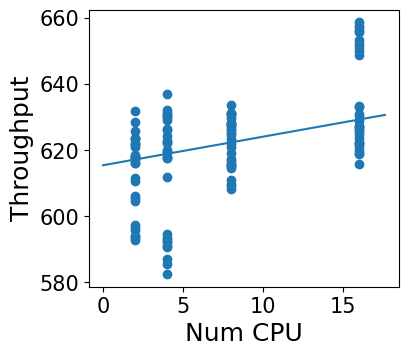

Test rmse = 0.2835682956961919, Train rmse = 0.2464373389425038
Group Id: 2, wl name tpch, terminal num 1
[0.3217342433471444, 0.24201532650016824, 0.21931258236255613, 0.2695105178203119, 0.226800209251154]
NRMSE from 2 to 4 is 0.25587457585626694
[0.27853370075390094, 0.244320511560665, 0.2427323982429166, 0.22186024983314556, 0.27003776181398587]
NRMSE from 2 to 8 is 0.25149692444092275
[0.22830131163740314, 0.2197101534501302, 0.23300300920662673, 0.31372017264523683, 0.240862573579186]
NRMSE from 2 to 16 is 0.2471194441037166
[0.2748523152280318, 0.2543525763829543, 0.23910896492257352, 0.27471649726073616, 0.22112005760996356]
NRMSE from 4 to 8 is 0.2528300822808519
[0.2580841332854187, 0.22336149598679303, 0.25875125773662155, 0.3087076451395288, 0.26287235330373976]
NRMSE from 4 to 16 is 0.2623553770904204
[0.22452776264379246, 0.2655403454969143, 0.25234616158933754, 0.25919870176113535, 0.23983072726526172]
NRMSE from 8 to 16 is 0.2482887397512883


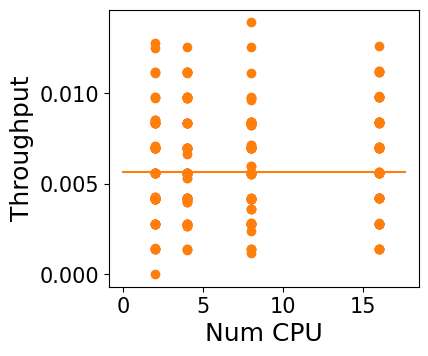

Test rmse = 0.2529941905872445, Train rmse = 0.21692663553049643
Group Id: 3, wl name twitter, terminal num 32
[0.29943276961777415, 0.3025078262112681, 0.2872045785822178, 0.29933263602207183, 0.3134667361213183]
NRMSE from 2 to 4 is 0.30038890931093004
[0.24513105694690804, 0.29818500276764265, 0.3148169992334371, 0.29791064558611513, 0.31852122351930945]
NRMSE from 2 to 8 is 0.29491298561068247
[0.2605682922472182, 0.295780845331265, 0.3412594351446251, 0.28201601749117317, 0.2197872035532849]
NRMSE from 2 to 16 is 0.27988235875351325
[0.31404067794659923, 0.29951378937949236, 0.28461813343857145, 0.3162160612837794, 0.3339207802764246]
NRMSE from 4 to 8 is 0.3096618884649734
[0.2594678728689674, 0.2817232915957416, 0.2547815201559771, 0.27354051894754416, 0.24460739352251848]
NRMSE from 4 to 16 is 0.26282411941814976
[0.2567106470277488, 0.28229851759888486, 0.26327842378091604, 0.27292720394407405, 0.2287306693349966]
NRMSE from 8 to 16 is 0.26078909233732406


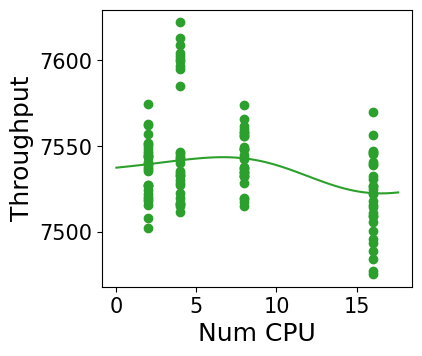

Test rmse = 0.2847432256492622, Train rmse = 0.22994291824619936
Group Id: 4, wl name twitter, terminal num 8
[0.2998301316626845, 0.2959982218947085, 0.2956717946259572, 0.3010524453978746, 0.27993602803870665]
NRMSE from 2 to 4 is 0.2944977243239863
[0.3558527121353591, 0.3427396351800071, 0.34238468244867587, 0.343235034720496, 0.36004330955657876]
NRMSE from 2 to 8 is 0.3488510748082233
[0.29080764300855727, 0.28829155196148976, 0.28684716900515606, 0.2919435221742785, 0.2849045734607922]
NRMSE from 2 to 16 is 0.28855889192205475
[0.25890009730207453, 0.2609126413584002, 0.2591305900379078, 0.2571296608955933, 0.2532758562073442]
NRMSE from 4 to 8 is 0.257869769160264
[0.30772086079506267, 0.3803249383359674, 0.301569236945016, 0.29783998574735243, 0.33731040545688834]
NRMSE from 4 to 16 is 0.32495308545605733
[0.26221360852636577, 0.2402831672887496, 0.24966091596875337, 0.23355055552794654, 0.25604918923453396]
NRMSE from 8 to 16 is 0.24835148730926987


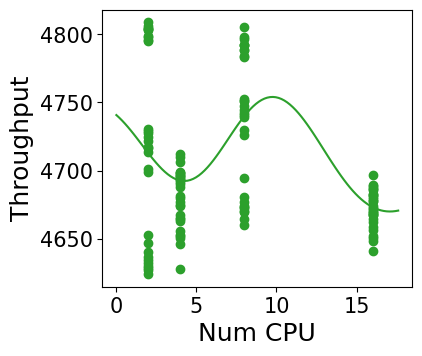

Test rmse = 0.29384700549664267, Train rmse = 0.26197074632259565
Group Id: 7, wl name tpcc, terminal num 8
[0.33966781030621385, 0.371600758783714, 0.33539432460688956, 0.3179914428799145, 0.34270628609084514]
NRMSE from 2 to 4 is 0.3414721245335154
[0.37814567669111776, 0.32974074714408275, 0.3422680661897033, 0.34091159574842916, 0.3354282765381755]
NRMSE from 2 to 8 is 0.34529887246230173
[0.2606640585649457, 0.22502386191683596, 0.24292264094739133, 0.2735554371897942, 0.21743177455254017]
NRMSE from 2 to 16 is 0.2439195546343015
[0.3337063494715189, 0.33082085058293514, 0.34166344374878954, 0.3180801471444495, 0.367857787411707]
NRMSE from 4 to 8 is 0.33842571567188
[0.27412312302692854, 0.23225729851522273, 0.2532831420027137, 0.25081563036709176, 0.23474901829693035]
NRMSE from 4 to 16 is 0.24904564244177743
[0.24226197196294172, 0.21921107783326324, 0.271304769003291, 0.2798865643614699, 0.22176127518634295]
NRMSE from 8 to 16 is 0.24688513166946174


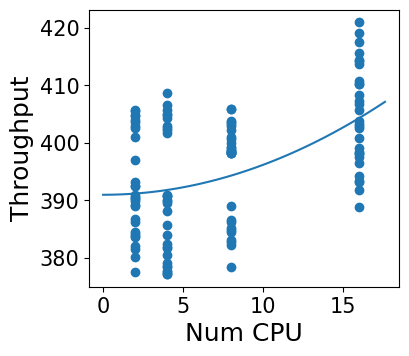

Test rmse = 0.2941745069022063, Train rmse = 0.26043716908344616
Group Id: 8, wl name tpcc, terminal num 4
[0.3064750166683742, 0.2856735442166605, 0.2399354218746177, 0.32448929629218737, 0.27032225891455536]
NRMSE from 2 to 4 is 0.285379107593279
[0.3012800553859637, 0.34148750804345007, 0.28321868666684474, 0.29152784262228176, 0.27470163138381865]
NRMSE from 2 to 8 is 0.2984431448204718
[0.2338520904721612, 0.23745444148172518, 0.24626994835644975, 0.25305167461459765, 0.27729023909780565]
NRMSE from 2 to 16 is 0.24958367880454788
[0.31062940386140847, 0.37294586083835646, 0.31825630743667105, 0.33276944578188805, 0.3228666509784028]
NRMSE from 4 to 8 is 0.3314935337793453
[0.22022550952296524, 0.20299086162196614, 0.20788209668871416, 0.24105012620846347, 0.2310143159667627]
NRMSE from 4 to 16 is 0.22063258200177432
[0.26204177785575866, 0.2443326475933408, 0.25176917919187436, 0.2647290903093705, 0.24814505993886984]
NRMSE from 8 to 16 is 0.25420355097784286


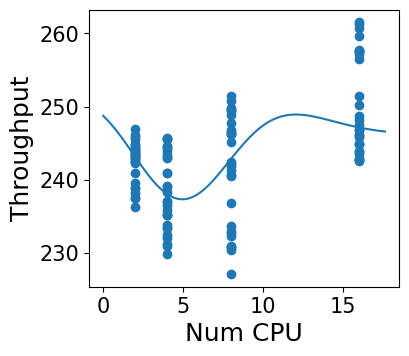

Test rmse = 0.27328926632954353, Train rmse = 0.23260889159261566
Group Id: 9, wl name twitter, terminal num 4
[0.3166747898161676, 0.3272550626407938, 0.31511587270875757, 0.3133283857792623, 0.3381873282197727]
NRMSE from 2 to 4 is 0.3221122878329508
[0.2994778057168007, 0.29285187787573, 0.2894817077422263, 0.2804884195551127, 0.2875236533930144]
NRMSE from 2 to 8 is 0.2899646928565768
[0.3447335410540111, 0.34925215189063974, 0.3415670510798526, 0.3212277617613897, 0.33172638306749247]
NRMSE from 2 to 16 is 0.3377013777706771
[0.25178359359775393, 0.2425227589586608, 0.23614535828115052, 0.25842619590321053, 0.26533170831188635]
NRMSE from 4 to 8 is 0.25084192301053243
[0.29698345392503445, 0.308171021124685, 0.29765742205363455, 0.2889714108370155, 0.3057557081322712]
NRMSE from 4 to 16 is 0.29950780321452813
[0.34533534457628606, 0.3365301267173768, 0.3262258001857098, 0.35202469485160215, 0.3331882849675732]
NRMSE from 8 to 16 is 0.3386608502597096


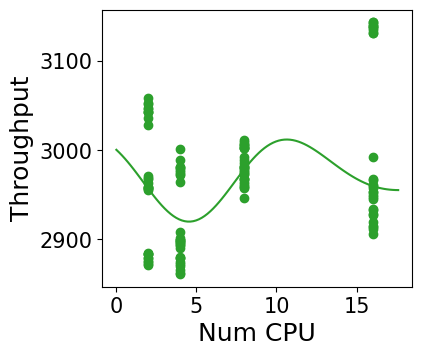

Test rmse = 0.3064648224908292, Train rmse = 0.28923816268645375
Overall test nrmse: 0.2841544733074172, train 0.24822312320061585


In [22]:
all_tests, all_trains = [], []
all_results['SVM'] = {}
all_times['SVM'] = {}

for ty, curr_data in data_by_type.items():
    name = curr_data.wl_names[0]
    term = curr_data.terminal_num[0]
    if name not in all_results['SVM']:
        all_results['SVM'][name] = {}
        all_times['SVM'][name] = {}
    print(f'Group Id: {ty}, wl name {name}, terminal num {term}')
    X = get_cpu_nums_as_X(curr_data.cpu_nums)
    y = np.array(curr_data.wl_throughput)
    test_r2_mean, train_r2_mean, train_time = build_svm_model(X, y, curr_data.wl_names[0], 'group', 
                                                              curr_data.wl_groups[0], 
                                                              plot=OVERALL_PLOT, show_fig=True)
    print('Test rmse = {}, Train rmse = {}'.format(test_r2_mean, train_r2_mean))   
    all_tests.append(test_r2_mean)
    all_trains.append(train_r2_mean)
    all_results['SVM'][name][term] = test_r2_mean
    all_times['SVM'][name][term] = train_time

print('Overall test nrmse: {}, train {}'.format(np.mean(all_tests), np.mean(all_trains)))

## LME

In [23]:
random_effect = 'EXPR_ID'
fixed_effect = 'SKU_VALUE'
target_metric = 'throughput'

In [24]:
import statsmodels
print(statsmodels.__version__)
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.tools.sm_exceptions import ConvergenceWarning

0.14.0


In [25]:
def plot_lmm_graphs_all(model_parameters_df, fixed_effects_cov, data, groups, metric, fig_name, show_fig=False):
    n_groups = groups.size
    fig, ax = plt.subplots(figsize=(4,3.6))
    
    t = np.linspace(np.max(data[fixed_effect]), np.min(data[fixed_effect]), num=100)
    # t = np.linspace(np.max(data['RUN_TIME']), np.min(data['RUN_TIME']), num=100)
    color_map = ["darkorange", "limegreen", "royalblue"] #, "#2ecc71"]

    for expr_idx, c in zip(groups, color_map):
        group_data = data.loc[data[random_effect] == expr_idx]
        # ax.scatter(group_data[fixed_effect], group_data[metric], color=c)
        group_data.plot.scatter(fixed_effect, metric, ax=ax, color=c)
        group_params = model_parameters_df.loc[expr_idx]
        # group_params = model_parameters_df.loc[model_parameters_df[random_effect] == expr_idx]|
        regression_line = group_params['alpha'] + group_params['beta'] * t
        ax.plot(t, regression_line, color=c, linestyle='--')

        # This is derived by expanding the following expression using the bi-linearity of covariance:
        #     var(alpha_fe + alpha_re + (beta_fe + beta_re) * t)
        # We're assuming that cov(fe, re) = 0, which I believe is true?
        prediction_sd = np.sqrt(
            group_params['var_alpha'] + 2 * t * group_params['cov_alpha_beta'] + group_params['var_beta'] * t**2
            + fixed_effects_cov['intercept'] + 2 * t * fixed_effects_cov['intercept_slope'] + fixed_effects_cov['slope'] * t**2
        )
        upper_band, lower_band = regression_line + 2 * prediction_sd, regression_line - 2 * prediction_sd
        ax.fill_between(t, upper_band, lower_band, alpha=0.05, color=c)
    # ax.set_title(fig_name)
    ax.set_xlabel('Num CPU')
    ax.set_ylabel('Throughput')
    plt.savefig(f'figs/prediction/lmm_all_{fig_name}.pdf', bbox_inches = 'tight')
    if show_fig:
        plt.show()
    else:
        plt.close()

In [26]:
def build_lmm_models(X, y, expr_ids, feature_names, fig_name, plot=True, num_bins=10):

    metrics = [fixed_effect, random_effect, target_metric]
    zipped = zip(X, expr_ids, y)
    
    # append fixed effect and random effect to data
    curr_data = pd.DataFrame(zipped, columns=metrics)

    train_rmses, test_rmses = [], []
    num_cpus = np.sort(np.unique(X))
    
    k = 5
    train_time = 0
        
    kf = KFold(n_splits=k, shuffle=True)
    for train_index, test_index in kf.split(curr_data):
        start = time.time()
        
        data = curr_data.iloc[train_index]
        test = curr_data.iloc[test_index]
        with warnings.catch_warnings():
            # Parameter is often on the boundary
            warnings.simplefilter("ignore", ConvergenceWarning)
            # md = smf.mixedlm("{} ~ SKU_VALUE+CPU_UTILIZATION+MEM_UTILIZATION".format(target_metric), data, groups=data[random_effect], re_formula="~SKU_VALUE")
            md = smf.mixedlm("{} ~ SKU_VALUE".format(target_metric), data, groups=data[random_effect], re_formula="~SKU_VALUE")
            # groups to sku type and 
            mdf = md.fit(method=["cg"])#, max_iter=1000)
        y_predict = mdf.fittedvalues
        test_pred = mdf.predict(exog=test)
        end = time.time()
        train_time += end - start

        for i in range(len(num_cpus)):
            for j in range(i, len(num_cpus)):
                if i == j:
                    continue
                cpu_a = num_cpus[i] # smaller
                cpu_b = num_cpus[j] # larger
                curr_mask = [x_lab == cpu_a or x_lab == cpu_b for x_lab in test[fixed_effect].to_list()]
                
                curr_y_true = test[target_metric].to_numpy()[curr_mask]
                rmse = np.sqrt(((curr_y_true-test_pred[curr_mask])**2).mean())
                n_rmse = rmse / (np.max(curr_y_true)-np.min(curr_y_true))
                test_rmses.append(n_rmse)
                
                curr_mask = [x_lab == cpu_a or x_lab == cpu_b for x_lab in data[fixed_effect].to_list()]
                
                curr_y_true = data[target_metric].to_numpy()[curr_mask]
                rmse = np.sqrt(((curr_y_true-y_predict[curr_mask])**2).mean())
                n_rmse = rmse / (np.max(curr_y_true)-np.min(curr_y_true))
                train_rmses.append(n_rmse)
    
    train_time /= k
    
    # calculate overall rmse
    overall_train_rmse = np.mean(train_rmses)
    overall_test_rmse = np.mean(test_rmses)

    fe, re, recov = mdf.fe_params, mdf.random_effects, mdf.random_effects_cov

    groups = data[random_effect].unique()

    model_parameters_df = pd.DataFrame([
        [fe[0] + re[idx][0], fe[1] + re[idx][1], recov[idx].iloc[0, 0], recov[idx].iloc[0, 1], recov[idx].iloc[1, 1]]
        for idx in groups
    ], columns=['alpha', 'beta', 'var_alpha', 'cov_alpha_beta', 'var_beta'], index=groups)
    
    fixed_effects_cov = {
        'intercept': mdf.cov_params().loc['Intercept', 'Intercept'],
        'slope': mdf.cov_params().loc[fixed_effect, fixed_effect],
        'intercept_slope': mdf.cov_params().loc['Intercept', fixed_effect],
    }

    if plot:
        plot_lmm_graphs_all(model_parameters_df, fixed_effects_cov, curr_data, groups, target_metric, fig_name+"_"+target_metric, show_fig=True)
    # return overall_test_r2, overall_train_r2
    return overall_test_rmse, overall_train_rmse, train_time

Group Id: 1, wl name tpcc, terminal num 32


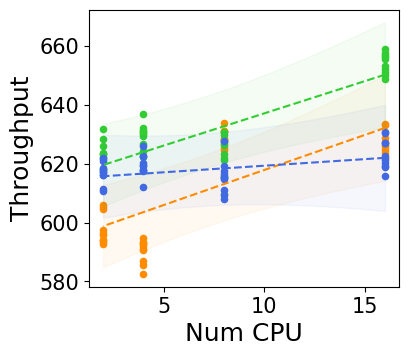

Test r2 = 0.31284057627164485, Train r2 = 0.15581374212928195
Group Id: 2, wl name tpch, terminal num 1


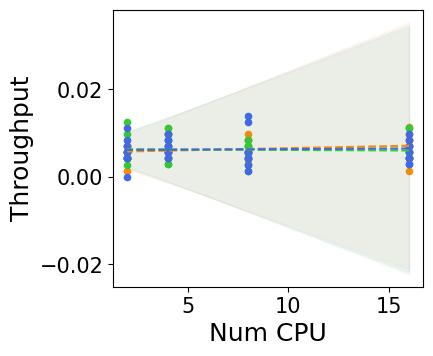

Test r2 = 0.2588710460412208, Train r2 = 0.20784686995062499
Group Id: 3, wl name twitter, terminal num 32


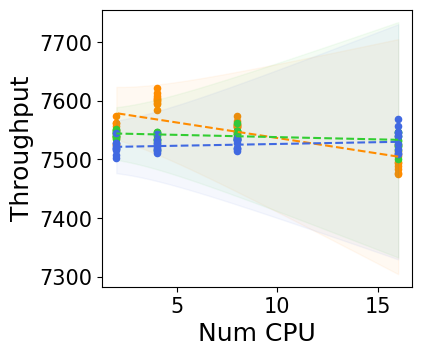

Test r2 = 0.3003893005300201, Train r2 = 0.17584545697067763
Group Id: 4, wl name twitter, terminal num 8


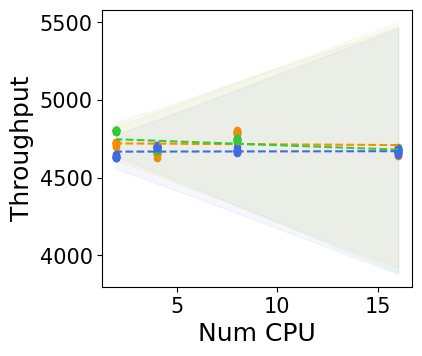

Test r2 = 0.35680301563365646, Train r2 = 0.2756004458781281
Group Id: 7, wl name tpcc, terminal num 8


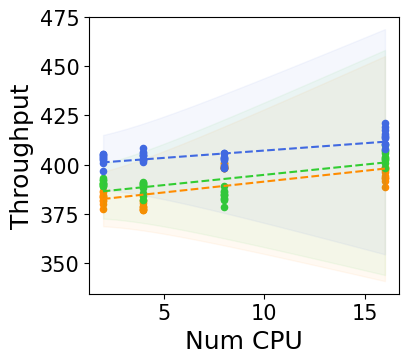

Test r2 = 0.32338331774191603, Train r2 = 0.15156430632611684
Group Id: 8, wl name tpcc, terminal num 4


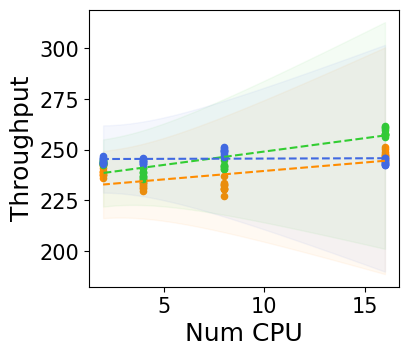

Test r2 = 0.2996974131501722, Train r2 = 0.16215349521802633
Group Id: 9, wl name twitter, terminal num 4


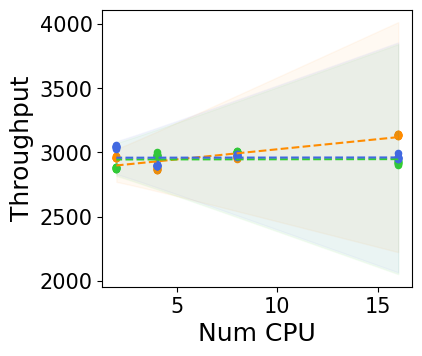

Test r2 = 0.3314579104556632, Train r2 = 0.23273355246611338
Overall test nrmse: 0.3119203685463277, train 0.1945082669912813


In [27]:
all_tests, all_trains = [], []
all_results['LMM'] = {}
all_times['LMM'] = {}
for ty, curr_data in data_by_type.items():
    name = curr_data.wl_names[0]
    term = curr_data.terminal_num[0]
    if name not in all_results['LMM']:
        all_results['LMM'][name] = {}
        all_times['LMM'][name] = {}
    print(f'Group Id: {ty}, wl name {name}, terminal num {term}')
    
    X = get_cpu_nums_as_X(curr_data.cpu_nums).flatten()
    y = curr_data.wl_throughput
    out_name = '{}_group{}_term{}'.format(curr_data.wl_names[0], ty, curr_data.terminal_num[0])
    
    expr_idxs = list(map(int, curr_data.run_idx))

    test_r2_mean, train_r2_mean, train_time = build_lmm_models(X, y,expr_idxs, all_top_7, 
                                                   out_name, plot=OVERALL_PLOT, num_bins=10)
    print('Test r2 = {}, Train r2 = {}'.format(test_r2_mean, train_r2_mean))
    
    all_tests.append(test_r2_mean)
    all_trains.append(train_r2_mean)
    all_results['LMM'][name][term] = test_r2_mean
    all_times['LMM'][name][term] = train_time
print('Overall test nrmse: {}, train {}'.format(np.mean(all_tests), np.mean(all_trains)))

## Gradient Boosting

In [28]:
from sklearn.ensemble import GradientBoostingRegressor

In [29]:
def plot_gb(model, X, y, workload_name, group_type, groupping_id, show_fig=False):
    colors = sns.color_palette()
    if workload_name == 'tpcc':
        color = colors[0]
    elif workload_name == 'tpch':
        color = colors[1]
    elif workload_name == 'twitter':
        color = colors[2]
    else:
        color = colors[3]
    x_new = np.linspace(0, np.max(X)*1.1, 100)
    y_new = model.predict(x_new[:, np.newaxis])
    
    plt.figure(figsize=(4,3.6))
    ax = plt.axes()
    ax.scatter(X.reshape(-1,1), y, color=color)
    ax.plot(x_new, y_new, color=color)
    
    ax.set_xlabel('Num CPU')
    ax.set_ylabel('Throughput')
    
    ax.axis('tight')
    plt.savefig(f'figs/prediction/gb_all_{workload_name}_{group_type}_{groupping_id}.pdf', bbox_inches = 'tight')
    if show_fig:
        plt.show()
    else:
        plt.close() 

In [30]:
def build_gb_model(X, y, wl_name, grouping_type, groupping_id, plot=False, show_fig=False):  
    # tuned_parameters = {}
    # tuned_parameters['n_estimators'] = [10, 50, 100, 500]
    # tuned_parameters['learning_rate'] = [0.0001, 0.001, 0.01, 0.1, 1.0]
    # tuned_parameters['subsample'] = [0.5, 0.7, 1.0]
    # tuned_parameters['max_depth'] = [3, 7, 9]

    tuned_parameters = {
        # "loss":["deviance"],
        "learning_rate": [0.01, 0.025, 0.05, 0.075, 0.1, 0.15, 0.2],
        # "min_samples_split": np.linspace(0.1, 0.5, 12),
        # "min_samples_leaf": np.linspace(0.1, 0.5, 12),
        "max_depth":[3,5,8],
        "max_features":["log2","sqrt"],
        # "criterion": ["friedman_mse",  "mae"],
        "subsample":[0.5, 0.618, 0.8, 0.85, 0.9, 0.95, 1.0],
        "n_estimators":[10, 50, 100]
    }

    model = GradientBoostingRegressor()
    clf = GridSearchCV(model, param_grid=tuned_parameters,verbose=0, n_jobs=-1,
                       cv=5, 
                       scoring=score_func, #'neg_root_mean_squared_error', #score_func, #'r2', 
                       return_train_score=True)
    clf.fit(X, y)
    
    best_params = clf.best_params_
    results = pd.DataFrame.from_dict(clf.cv_results_)
    results_best = results[results['params'] == best_params].reset_index()
    train_time = results_best['mean_fit_time'][0]
    
    # use the selected model to repredict
    train_rmses, test_rmses = [], []
    k = 5
    models = []   
    num_cpus = np.sort(np.unique(X))
    metrics = [X_label, y_label]
    zipped = zip(X, y)
    # append fixed effect and random effect to data
    overall_data = pd.DataFrame(zipped, columns=metrics)  
                
    kf = KFold(n_splits=k, shuffle=False)
    for i in range(len(num_cpus)):
        for j in range(i, len(num_cpus)):
            if i == j:
                continue
            cpu_a = num_cpus[i] # smaller
            cpu_b = num_cpus[j] # larger
            curr_data = overall_data[ (overall_data[X_label] == cpu_a) | (overall_data[X_label] == cpu_b) ]
            for train_index, test_index in kf.split(curr_data):
                data = curr_data.iloc[train_index]
                test = curr_data.iloc[test_index]
                X_train = data[X_label].to_numpy().reshape(-1,1)
                y_train = data[y_label].to_numpy()
                X_test = test[X_label].to_numpy().reshape(-1,1)
                y_test = test[y_label].to_numpy()
                test_pred = clf.predict(X_test)
                train_pred = clf.predict(X_train)
                rmse = np.sqrt(((y_test-test_pred)**2).mean())
                n_rmse = rmse / (np.max(y_test)-np.min(y_test))
                test_rmses.append(n_rmse)

                rmse = np.sqrt(((y_train-train_pred)**2).mean())
                n_rmse = rmse / (np.max(y_train)-np.min(y_train))
                train_rmses.append(n_rmse)            
            print(f'NRMSE from {num_cpus[i]} to {num_cpus[j]} is {np.mean(test_rmses[-k:])}')

    if plot:
        # plot the last one as example
        plot_gb(clf, X, y, wl_name, grouping_type, groupping_id, show_fig)
    overall_train_rmse = np.mean(train_rmses)
    overall_test_rmse = np.mean(test_rmses)
    
    return overall_test_rmse, overall_train_rmse, train_time

In [31]:
all_tests, all_trains = [], []
all_results['GB'] = {}
all_times['GB'] = {}
for ty, curr_data in data_by_type.items():
    name = curr_data.wl_names[0]
    term = curr_data.terminal_num[0]
    if name not in all_results['GB']:
        all_results['GB'][name] = {}
        all_times['GB'][name] = {}
    print(f'Group Id: {ty}, wl name {name}, terminal num {term}')
    X = get_cpu_nums_as_X(curr_data.cpu_nums)
    y = np.array(curr_data.wl_throughput)
    test_r2_mean, train_r2_mean, train_time = build_gb_model(X, y, curr_data.wl_names[0], 
                                                             'group', curr_data.wl_groups[0], 
                                                             plot=False, show_fig=False)
    print('Test r2 = {}, Train r2 = {}'.format(test_r2_mean, train_r2_mean))   
    all_tests.append(test_r2_mean)
    all_trains.append(train_r2_mean)
    all_results['GB'][name][term] = test_r2_mean
    all_times['GB'][name][term] = train_time
print('Overall test nrmse: {}, train {}'.format(np.mean(all_tests), np.mean(all_trains)))

Group Id: 1, wl name tpcc, terminal num 32
NRMSE from 2 to 4 is 0.3378911249176153
NRMSE from 2 to 8 is 0.28030691325759743
NRMSE from 2 to 16 is 0.21769811310873663
NRMSE from 4 to 8 is 0.2891869657203129
NRMSE from 4 to 16 is 0.22731647141915304
NRMSE from 8 to 16 is 0.25707753899021896
Test r2 = 0.26824618790227245, Train r2 = 0.2335691975748066
Group Id: 2, wl name tpch, terminal num 1
NRMSE from 2 to 4 is 0.25230186360016926
NRMSE from 2 to 8 is 0.25067631847194616
NRMSE from 2 to 16 is 0.24415381730802221
NRMSE from 4 to 8 is 0.24799737976909414
NRMSE from 4 to 16 is 0.2561511799155207
NRMSE from 8 to 16 is 0.2429521170942392
Test r2 = 0.2490387793598319, Train r2 = 0.21337699161212903
Group Id: 3, wl name twitter, terminal num 32
NRMSE from 2 to 4 is 0.28693425686454993
NRMSE from 2 to 8 is 0.2928294309537574
NRMSE from 2 to 16 is 0.27947319460270226
NRMSE from 4 to 8 is 0.2957011202294314
NRMSE from 4 to 16 is 0.252575367707954
NRMSE from 8 to 16 is 0.2610864940957017
Test r2 =

In [32]:
terminals = [4, 8, 32]
workloads = ['tpcc', 'twitter', 'tpch']
methods = ['Regression', 'SVM', 'LMM', 'GB']

for me in methods:
    curr_line = ''
    scs = []
    times = []
    for wl in workloads:
        if wl == 'tpch':
            sc = abs(all_results[me][wl][1])
            curr_line += f' {sc:.3f} &'
            scs.append(sc)
            times.append(all_times[me][wl][1])
        else:
            for ter in terminals:
                sc = abs(all_results[me][wl][ter])
                curr_line += f' {sc:.3f} &'
                scs.append(sc)
                times.append(all_times[me][wl][ter])
    curr_line += f' {np.mean(scs):.3}'
    curr_line += " \\\\ \cline{2-11}"
    curr_line = f'& {me} & ' + f' {np.mean(times):.4f} & ' + curr_line
    print(curr_line)

& Regression &  0.0013 &  0.296 & 0.311 & 0.291 & 0.363 & 0.386 & 0.313 & 0.253 & 0.316 \\ \cline{2-11}
& SVM &  0.0018 &  0.273 & 0.294 & 0.284 & 0.306 & 0.294 & 0.285 & 0.253 & 0.284 \\ \cline{2-11}
& LMM &  0.5407 &  0.300 & 0.323 & 0.313 & 0.331 & 0.357 & 0.300 & 0.259 & 0.312 \\ \cline{2-11}
& GB &  0.1142 &  0.264 & 0.293 & 0.268 & 0.292 & 0.286 & 0.278 & 0.249 & 0.276 \\ \cline{2-11}


In [33]:
print(all_results)

{'Regression': {'tpcc': {32: 0.2913453501127001, 8: 0.31123098579181724, 4: 0.29596456353321987}, 'tpch': {1: 0.25346617548886174}, 'twitter': {32: 0.3129594110021398, 8: 0.3856023057402724, 4: 0.36314812916608574}}, 'SVM': {'tpcc': {32: 0.2835682956961919, 8: 0.2941745069022063, 4: 0.27328926632954353}, 'tpch': {1: 0.2529941905872445}, 'twitter': {32: 0.2847432256492622, 8: 0.29384700549664267, 4: 0.3064648224908292}}, 'LMM': {'tpcc': {32: 0.31284057627164485, 8: 0.32338331774191603, 4: 0.2996974131501722}, 'tpch': {1: 0.2588710460412208}, 'twitter': {32: 0.3003893005300201, 8: 0.35680301563365646, 4: 0.3314579104556632}}, 'GB': {'tpcc': {32: 0.26824618790227245, 8: 0.29270924180832725, 4: 0.26377592320866194}, 'tpch': {1: 0.2490387793598319}, 'twitter': {32: 0.2780999774090161, 8: 0.2859855525403678, 4: 0.29155874048956953}}}


In [34]:
print(all_times)

{'Regression': {'tpcc': {32: 0.0009484291076660156, 8: 0.000857400894165039, 4: 0.0014552593231201172}, 'tpch': {1: 0.0015340805053710937}, 'twitter': {32: 0.0010551929473876954, 8: 0.0017624855041503905, 4: 0.0014322280883789062}}, 'SVM': {'tpcc': {32: 0.003165006637573242, 8: 0.0011883258819580078, 4: 0.0014387130737304687}, 'tpch': {1: 0.0032781124114990234}, 'twitter': {32: 0.0013921260833740234, 8: 0.0012281417846679687, 4: 0.0011539459228515625}}, 'LMM': {'tpcc': {32: 0.23971853256225586, 8: 0.39177355766296384, 4: 0.5886386871337891}, 'tpch': {1: 1.0911130905151367}, 'twitter': {32: 0.3760552883148193, 8: 0.6004693984985352, 4: 0.49708995819091795}}, 'GB': {'tpcc': {32: 0.06700053215026855, 8: 0.1516857624053955, 4: 0.14589238166809082}, 'tpch': {1: 0.15769319534301757}, 'twitter': {32: 0.06764864921569824, 8: 0.1391958236694336, 4: 0.07032904624938965}}}
